# Simple Sequential Neural Network with Pytorch trained on Fruits-360 data

Credit for data:
* Horea Muresan, [Mihai Oltean](https://mihaioltean.github.io), [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

In [37]:
# input constants
import os
import dotenv
import torch

dotenv.load_dotenv()
torch.manual_seed(42)

DATA_DIR = os.getenv('DATA_DIR')
training_data_dir = os.path.join(DATA_DIR, 'Training')
test_data_dir = os.path.join(DATA_DIR, 'Test')
partitions = list(set(os.listdir(training_data_dir)))
VALIDATION_RATIO = float(os.getenv('VALIDATION_RATIO'))

BATCH_SIZE = int(os.getenv('BATCH_SIZE'))
LEARNING_RATE = float(os.getenv('LEARNING_RATE'))
EPOCHS= int(os.getenv('EPOCHS'))

MODEL_NAME = 'SSNN'

In [38]:
print(f"partitions ({len(partitions)} unique) first 10: {partitions[:10]}")
print(f"validation_ratio: {VALIDATION_RATIO}")
print(f"batch_size: {BATCH_SIZE}")
print(f"learning rate (lr): {LEARNING_RATE}")
print(f"epochs: {EPOCHS}")

partitions (131 unique) first 10: ['Peach', 'Mulberry', 'Lychee', 'Lemon Meyer', 'Chestnut', 'Carambula', 'Plum 3', 'Grape Pink', 'Dates', 'Cactus fruit']
validation_ratio: 0.15
batch_size: 64
learning rate (lr): 0.001
epochs: 5


# EDA

DATA_DIR listdir: ['test-multiple_fruits', 'readme.md', 'Training', 'Test', 'LICENSE', 'papers']


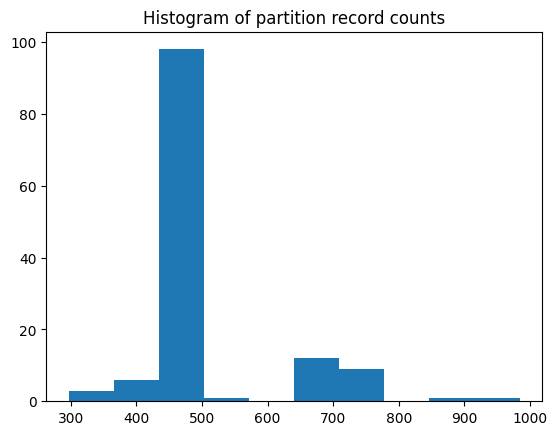

In [10]:
import matplotlib.pyplot as plt

# print data dir content
print(f"DATA_DIR listdir: {os.listdir(DATA_DIR)}")

# show partition frequency
counter = {}
for p in partitions:
    p_dir = os.path.join(training_data_dir, p)
    counter[p] = len(os.listdir(p_dir))

fig, ax = plt.subplots()
ax.hist(counter.values())
ax.set_title('Histogram of partition record counts')
plt.show()

# Data Ingestion

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# trainin and validation data
dataset = datasets.ImageFolder(
    root=training_data_dir,
    transform=ToTensor()
)
classes = dataset.classes

valid_data_len = int(len(dataset) * VALIDATION_RATIO)
train_data_len = len(dataset) - valid_data_len
train_data, valid_data = torch.utils.data.random_split(
    dataset=dataset, 
    lengths=[train_data_len, valid_data_len]
)

# test data
test_data = datasets.ImageFolder(
    root=test_data_dir,
    transform=ToTensor()
)

In [12]:
print(f"len(train_and_valid_data): {len(dataset)}")
print(f"len(classes): {len(classes)}")
print(f"len(train_data): {len(train_data)} ({len(train_data)/len(dataset)*100:.4f}%)")
print(f"len(valid_data): {len(valid_data)} ({len(valid_data)/len(dataset)*100:.4f}%)")
print(f"len(test_data): {len(test_data)}")

len(train_and_valid_data): 67692
len(classes): 131
len(train_data): 57539 (85.0012%)
len(valid_data): 10153 (14.9988%)
len(test_data): 22688


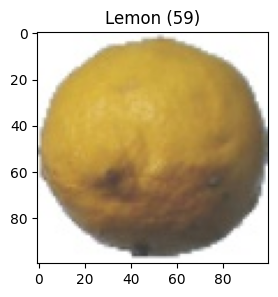

In [13]:
import matplotlib.pyplot as plt

def img_show_single(img, label):
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"{classes[label]} ({label})")
    
img_show_single(*train_data[1234])

In [14]:
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_data, 
    batch_size=BATCH_SIZE * 2,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_data, 
    batch_size=BATCH_SIZE * 2,
    shuffle=True,
    num_workers=2
)

In [15]:
# check shapes in first batch
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 100, 100])
Shape of y: torch.Size([128]) torch.int64


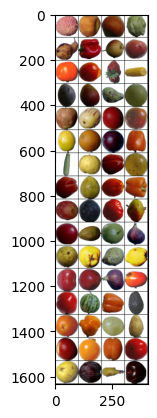

--------------  --------------  ------------------  ------------------
Lychee          Peach           Nut Forest          Kohlrabi
Pear Abate      Pepper Red      Pear Forelle        Potato Red Washed
Clementine      Tomato 1        Strawberry Wedge    Corn
Plum 3          Mango Red       Pear Stone          Grape White 4
Apple Red 3     Pepino          Nectarine           Tomato Maroon
Maracuja        Orange          Plum 2              Pepper Orange
Corn Husk       Apple Golden 1  Tomato Heart        Grape White 3
Tomato Heart    Guava           Tomato 1            Pepper Orange
Grape Pink      Blueberry       Tomato 3            Apple Red Yellow 2
Cherry Wax Red  Papaya          Tomato not Ripened  Fig
Guava           Quince          Pear Stone          Quince
Cherry 2        Pomegranate     Fig                 Kaki
Tomato 2        Watermelon      Pepper Orange       Avocado ripe
Tangelo         Pepper Yellow   Grape White         Potato White
Nectarine       Physalis        Aprico

In [33]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# function to show an image
def img_show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a block of training data and labels
nb_in_row = 4
xb, yb = next(iter(train_loader))
grid = torchvision.utils.make_grid(
    tensor=xb, 
    nrow=nb_in_row
)

# show images
img_show_grid(grid)

# print labels
k, m = divmod(len(yb), nb_in_row) 
yb_lists = [yb[i*nb_in_row : min((i+1)*nb_in_row, len(yb))] for i in range(k+1)]
label_lists = [[classes[y] for y in yb_list] for yb_list in yb_lists]
print(tabulate(label_lists))

# Compute instance

In [18]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [19]:
class DeviceDataLoader():
    """
    DataLoader wrapper to move data to a device
    """
    
    @classmethod
    def __to_device(cls, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [cls.__to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield self.__to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Model Configuration

## Classification model utilities

In [21]:
def accuracy(
    pred: torch.Tensor, 
    labels: torch.Tensor
) -> float:
    """
    Custom accuracy metric
    """
    _, preds = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
from torch import nn
from typing import List, Dict


class ClassificationBase(nn.Module):
    """
    Base class for multilabel classification models
    """    
    def training_step(self, batch: List[torch.Tensor]) -> float:
        X, y = batch
        
        # Compute prediction error
        pred = self(X)
        loss = self._loss_fn(pred, y)
        
        return loss
    
    def validation_step(self, batch: List[torch.Tensor]) -> Dict:
        X, y = batch
        
        # Compute prediction error
        pred = self(X)
        loss = self._loss_fn(pred, y)
        
        # Compute accuracy
        acc = self._accuracy_fn(pred, y)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs: Dict) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch: int, result: Dict) -> str:
        print(f"Epoch [{epoch}], \
              train_loss: {result['train_loss']:.4f}, \
              val_loss: {result['val_loss']:.4f}, \
              val_acc: {result['val_acc']:.4f}"
        )

In [24]:
from tqdm import tqdm
from typing import List, Dict


def evaluate(
    model: nn.Module, 
    valid_loader: DataLoader
) -> str:
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)


def fit(
    epochs: int, 
    lr: float, 
    model: nn.Module, 
    train_loader: DataLoader, 
    valid_loader: DataLoader, 
    opt_func: callable = torch.optim.SGD
) -> List[Dict]:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Input data specific configuration

In [25]:
import random
rnd_index = random.randint(0, len(train_data))
rnd_tensor, rnd_label = train_data[rnd_index]
rnd_tensor_flat = nn.Flatten(0,-1)(rnd_tensor) 
input_dim = list(rnd_tensor_flat.size())[0]
print(f"input_dim: {input_dim}")

input_dim: 30000


In [26]:
class SimpleSequentialNetwork(ClassificationBase):
    
    def __init__(self, input_dim, output_dim, loss_fn, accuracy_fn):
        super().__init__()
        self._loss_fn = loss_fn
        self._accuracy_fn = accuracy_fn
        self._flatten = nn.Flatten()
        self._linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),  # input layer
            nn.ReLU(),
            nn.Linear(512, 256),  # hidden layer
            nn.ReLU(),
            nn.Linear(256, output_dim)  # output layer
        )
        
    def forward(self, xb):
        # flatten batch of x (xb) into vectors
        x = self._flatten(xb)
        # apply layers & activation functions
        logits = self._linear_relu_stack(x)
        return logits
    
    
model = SimpleSequentialNetwork(
    input_dim=input_dim,
    output_dim=len(classes),
    loss_fn=nn.CrossEntropyLoss(),
    accuracy_fn=accuracy
)
model = model.to(device)
print(model)

SimpleSequentialNetwork(
  (_loss_fn): CrossEntropyLoss()
  (_flatten): Flatten(start_dim=1, end_dim=-1)
  (_linear_relu_stack): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=131, bias=True)
  )
)


# Training job

In [27]:
# performance before training
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 4.875685691833496, 'val_acc': 0.018285537138581276}]

In [28]:
# training model
model.train()
history += fit(
    model=model,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    train_loader=train_loader,
    valid_loader=valid_loader,
    opt_func=torch.optim.SGD
)

  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [0],               train_loss: 4.7784,               val_loss: 4.6707,               val_acc: 0.0584


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [1],               train_loss: 4.4747,               val_loss: 4.2335,               val_acc: 0.0814


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [2],               train_loss: 3.8580,               val_loss: 3.4841,               val_acc: 0.2358


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [3],               train_loss: 3.0907,               val_loss: 2.8060,               val_acc: 0.3460


Epoch [4],               train_loss: 2.4353,               val_loss: 2.2992,               val_acc: 0.3879


In [29]:
# training model (cont'd)
model.train()
history += fit(
    model=model,
    epochs=EPOCHS,
    lr=LEARNING_RATE/2,
    train_loader=train_loader,
    valid_loader=valid_loader,
    opt_func=torch.optim.SGD
)

  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [0],               train_loss: 2.0285,               val_loss: 1.9706,               val_acc: 0.5974


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [1],               train_loss: 1.8129,               val_loss: 1.7491,               val_acc: 0.6169


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [2],               train_loss: 1.6322,               val_loss: 1.5747,               val_acc: 0.6730


  0%|          | 0/900 [00:00<?, ?it/s]          

Epoch [3],               train_loss: 1.4814,               val_loss: 1.4971,               val_acc: 0.6376


Epoch [4],               train_loss: 1.3491,               val_loss: 1.3325,               val_acc: 0.6997


# Evaluations

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

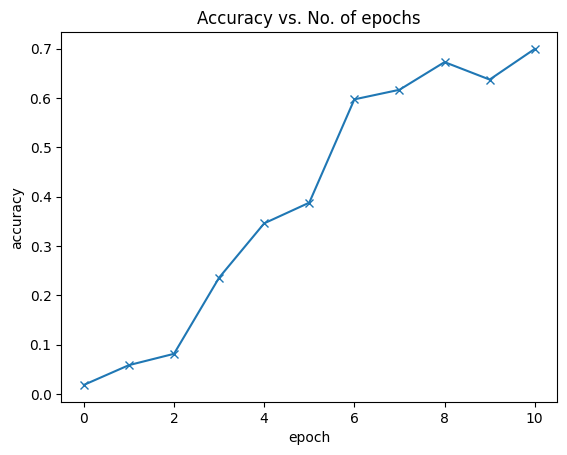

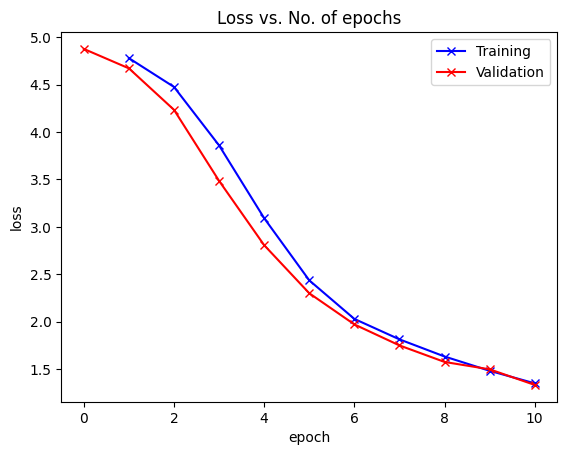

In [31]:
plot_accuracies(history)
plot_losses(history)

In [32]:
model.eval()
evaluate(model, test_loader)

{'val_loss': 1.7393635511398315, 'val_acc': 0.5987096428871155}

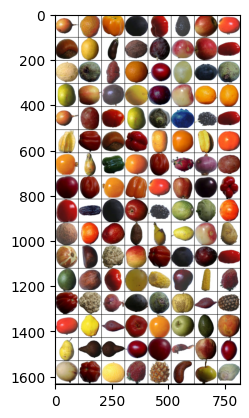

Ground truth
------------------  ---------------  ----------------  ------------------  --------------  -------------------  ------------------  ----------------
Granadilla          Mandarine        Pepper Yellow     Grape Blue          Tomato 3        Avocado ripe         Apple Red 2         Kaki
Nut Forest          Lemon            Eggplant          Cocos               Plum            Cherry Rainier       Apple Crimson Snow  Tomato 2
Cantaloupe 2        Pear Stone       Strawberry Wedge  Orange              Tamarillo       Grape White          Blueberry           Pear Stone
Pomelo Sweetie      Apple Pink Lady  Passion Fruit     Peach 2             Plum 2          Cherry Rainier       Lemon Meyer         Lemon Meyer
Granadilla          Grape Pink       Tomato 1          Pomelo Sweetie      Eggplant        Huckleberry          Mulberry            Tomato 2
Physalis with Husk  Tomato Heart     Nut Forest        Pepper Red          Kumquats        Tomato Yellow        Carambula           

In [39]:
from tabulate import tabulate

# get a block of test data and labels
nb_in_row = 8
xb, yb = next(iter(test_loader))
grid = torchvision.utils.make_grid(
    tensor=xb, 
    nrow=nb_in_row
)

# show images (function defined earlie)
img_show_grid(grid)

# print labels
k, m = divmod(len(yb), nb_in_row) 
yb_lists = [yb[i*nb_in_row : min((i+1)*nb_in_row, len(yb))] for i in range(k+1)]
ground_label_lists = [[classes[y] for y in yb_list] for yb_list in yb_lists]
print("Ground truth")
print(tabulate(ground_label_lists))

In [40]:
# prediction
logits = model(xb)
_, predicted = torch.max(logits, 1)
predicted_label_lists = [classes[y_hat] for y_hat in predicted]

ground_label_lists = [classes[y] for y in yb]
comparison = [['Match', 'Ground truth', 'Predicted'],['-'*5,'-'*10,'-'*10]]
for (gt, pred) in zip(ground_label_lists, predicted_label_lists):
    comparison.append([True if gt == pred else '', gt, pred])

print(tabulate(comparison))

-----  -------------------  -------------------
Match  Ground truth         Predicted
-----  ----------           ----------
       Granadilla           Pear 2
       Mandarine            Tangelo
True   Pepper Yellow        Pepper Yellow
True   Grape Blue           Grape Blue
True   Tomato 3             Tomato 3
True   Avocado ripe         Avocado ripe
True   Apple Red 2          Apple Red 2
True   Kaki                 Kaki
True   Nut Forest           Nut Forest
       Lemon                Maracuja
True   Eggplant             Eggplant
       Cocos                Pear Forelle
       Plum                 Chestnut
True   Cherry Rainier       Cherry Rainier
       Apple Crimson Snow   Tomato 4
True   Tomato 2             Tomato 2
       Cantaloupe 2         Apple Golden 2
       Pear Stone           Tomato not Ripened
       Strawberry Wedge     Nut Pecan
True   Orange               Orange
True   Tamarillo            Tamarillo
True   Grape White          Grape White
True   Blueberry       

In [41]:
torch.save(model.state_dict(), f"{MODEL_NAME}.pth")
print(f"Saved model {MODEL_NAME}.pth")

Saved model SSNN.pth
